In [5]:
# pip install diffusers

In [19]:
# pip install transformers

In [7]:
# pip install git+https://github.com/tencent-ailab/IP-Adapter.git

In [15]:
# pip install accelerate

In [1]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler, AutoencoderKL
from ip_adapter.ip_adapter_faceid import IPAdapterFaceIDPlus
from huggingface_hub import hf_hub_download
from insightface.app import FaceAnalysis
from insightface.utils import face_align
import cv2

c:\Users\VIA\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_model_path = "SG161222/Realistic_Vision_V4.0_noVAE"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
ip_plus_ckpt = hf_hub_download(repo_id="h94/IP-Adapter-FaceID", filename="ip-adapter-faceid-plusv2_sd15.bin", repo_type="model")

device = "cpu"

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)

if device == "cpu":
    __dtype = torch.float32
else:
    __dtype = torch.float16

vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=__dtype) 
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=__dtype, 
    scheduler=noise_scheduler,
    vae=vae
).to(device)

ip_model_plus = IPAdapterFaceIDPlus(pipe, image_encoder_path, ip_plus_ckpt, device, torch_dtype=__dtype)

app = FaceAnalysis(name="buffalo_l", providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))



Loading pipeline components...: 100%|██████████| 5/5 [00:01<00:00,  4.45it/s]
c:\Users\VIA\AppData\Local\Programs\Python\Python310\lib\site-packages\diffusers\models\lora.py:208: FutureWarning: `LoRALinearLayer` is deprecated and will be removed in version 1.0.0. Use of `LoRALinearLayer` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRALinearLayer", "1.0.0", deprecation_message)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\VIA/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\VIA/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\VIA/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\VIA/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\VIA/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
se

In [3]:
def generate_image(images, prompt, photorealistic, negative_prompt = 'low-quality'):
    if photorealistic == True:
        face_strength=1.3
        likeness_strength = 1
    else:
        face_strength=0.1
        likeness_strength = 0.8
    print(face_strength, likeness_strength)
    
    faceid_all_embeds = []
    first_iteration = True
    for image in images:
        face = cv2.imread(image)
        faces = app.get(face)
        faceid_embed = torch.from_numpy(faces[0].normed_embedding).unsqueeze(0)
        faceid_all_embeds.append(faceid_embed)
        if(first_iteration):
            face_image = face_align.norm_crop(face, landmark=faces[0].kps, image_size=224) # you can also segment the face
            first_iteration = False
            
    average_embedding = torch.mean(torch.stack(faceid_all_embeds, dim=0), dim=0)
    
    image = ip_model_plus.generate(
        prompt=prompt, negative_prompt=negative_prompt, faceid_embeds=average_embedding,
        scale=likeness_strength, face_image=face_image, shortcut=True, s_scale=face_strength, width=512, height=512, num_inference_steps=30, num_samples=2
    )

    return image  

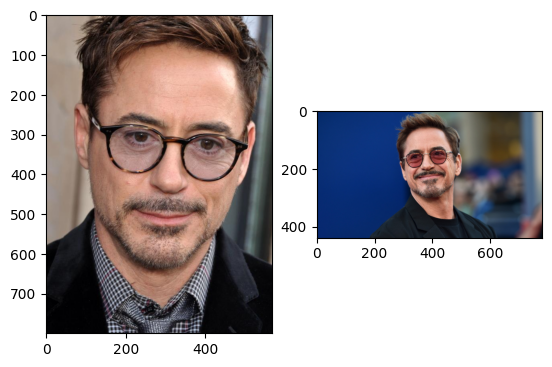

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(cv2.cvtColor(cv2.imread("ironman1.jpg"), cv2.COLOR_BGR2RGB))
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(cv2.cvtColor(cv2.imread("ironman2.jpg"), cv2.COLOR_BGR2RGB))


In [28]:
my_imgs = ["ironman1.jpg","ironman2.jpg"]
result = generate_image(my_imgs,"an watercolour style picture of a man",photorealistic=True, negative_prompt='low quality')

1.3 1


c:\Users\VIA\AppData\Local\Programs\Python\Python310\lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4
100%|██████████| 30/30 [42:46<00:00, 85.54s/it] 


In [39]:
result[3].save("wc4.jpg")

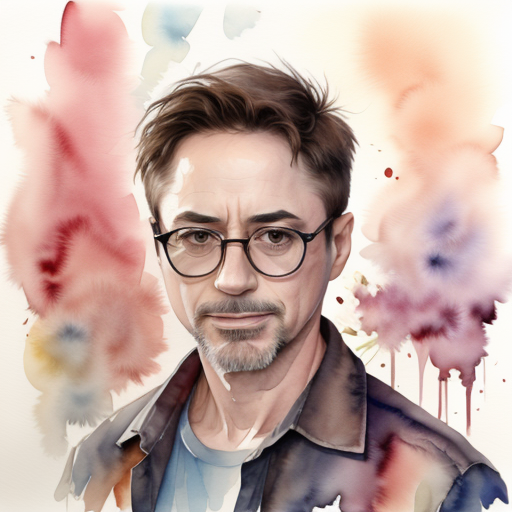

In [38]:
result[3]